In [36]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [37]:
from dubins_planner import DubinsPath

In [38]:
class Node:
    def __init__(self, x, y, yaw):
        self.x = x
        self.y = y
        self.path_x = []
        self.path_y = []
        self.parent = None
        self.cost = 0.0
        self.yaw = yaw
        self.path_yaw = []

In [39]:
class RRTStarDubins:
    def __init__(self, start, goal, obstacle_list, rand_area,
                 goal_sample_rate=10,
                 max_iter=100,
                 connect_circle_dist=50.0,
                 robot_radius=0.0,
                 ):

        self.start = Node(start[0], start[1], start[2])
        self.end = Node(goal[0], goal[1], goal[2])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.connect_circle_dist = connect_circle_dist

        self.curvature = 1.0  # for dubins path
        self.goal_yaw_th = np.deg2rad(1.0)
        self.goal_xy_th = 0.5
        self.robot_radius = robot_radius
        self.dubbins_planner = DubinsPath()

    def planning(self, search_until_max_iter=True):

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd)

            if self.check_collision(new_node, self.obstacle_list, self.robot_radius):
                near_indexes = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_indexes)
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_indexes)

            if (not search_until_max_iter) and new_node:  # check reaching the goal
                last_index = self.search_best_goal_node()
                if last_index:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index:
            return self.generate_final_course(last_index)
        else:
            print("Cannot find path")

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):

        goal_indexes = []
        for (i, node) in enumerate(self.node_list):
            if self.calc_dist_to_goal(node.x, node.y) <= self.goal_xy_th:
                goal_indexes.append(i)

        # angle check
        final_goal_indexes = []
        for i in goal_indexes:
            if abs(self.node_list[i].yaw - self.end.yaw) <= self.goal_yaw_th:
                final_goal_indexes.append(i)

        if not final_goal_indexes:
            return None

        min_cost = min([self.node_list[i].cost for i in final_goal_indexes])
        for i in final_goal_indexes:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """"""  """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt(np.log(nnode) / nnode)
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == self.node_list[i]:
                        node.parent = edge_node
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(self.node_list[i])

    def calc_new_cost(self, from_node, to_node):

        _, _, _, _, course_lengths = self.dubbins_planner.plan_dubins_path(
            from_node.x, from_node.y, from_node.yaw,
            to_node.x, to_node.y, to_node.yaw, self.curvature)

        cost = sum([abs(c) for c in course_lengths])

        return from_node.cost + cost

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

    def steer(self, from_node, to_node):

        px, py, pyaw, mode, course_lengths = \
            self.dubbins_planner.plan_dubins_path(
                from_node.x, from_node.y, from_node.yaw,
                to_node.x, to_node.y, to_node.yaw, self.curvature)

        if len(px) <= 1:  # cannot find a dubins path
            return None

        new_node = copy.deepcopy(from_node)
        new_node.x = px[-1]
        new_node.y = py[-1]
        new_node.yaw = pyaw[-1]

        new_node.path_x = px
        new_node.path_y = py
        new_node.path_yaw = pyaw
        new_node.cost += sum([abs(c) for c in course_lengths])
        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_index):
        print("final")
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_index]
        while node.parent:
            for (ix, iy) in zip(reversed(node.path_x), reversed(node.path_y)):
                path.append([ix, iy])
            node = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return np.hypot(dx, dy)

    def get_random_node(self):

        if np.random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(-np.pi, np.pi)
                       )
        else:  # goal point sampling
            rnd = Node(self.end.x, self.end.y, self.end.yaw)

        return rnd

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)
        return d, theta

In [40]:
np.random.seed(13)

obstacleList = [
    (5.5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
]  # [x,y,size(radius)]

# Set Initial parameters
start = [0.0, 0.0, np.deg2rad(10.0)]
goal = [10.0, 10.0, np.deg2rad(0.0)]

rnd_min = 0
rnd_max = 15

rrtstar_dubins = RRTStarDubins(start, goal, rand_area=[
                               rnd_min, rnd_max], obstacle_list=obstacleList, robot_radius=0.5)
path = rrtstar_dubins.planning(search_until_max_iter=False)

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 1
Iter: 2 , number of nodes: 1
Iter: 3 , number of nodes: 1
Iter: 4 , number of nodes: 2
Iter: 5 , number of nodes: 2
Iter: 6 , number of nodes: 3
Iter: 7 , number of nodes: 3
Iter: 8 , number of nodes: 3
Iter: 9 , number of nodes: 3
Iter: 10 , number of nodes: 3
Iter: 11 , number of nodes: 4
Iter: 12 , number of nodes: 4
Iter: 13 , number of nodes: 5
Iter: 14 , number of nodes: 6
Iter: 15 , number of nodes: 6
Iter: 16 , number of nodes: 7
Iter: 17 , number of nodes: 7
Iter: 18 , number of nodes: 7
Iter: 19 , number of nodes: 7
Iter: 20 , number of nodes: 7
Iter: 21 , number of nodes: 8
Iter: 22 , number of nodes: 8
Iter: 23 , number of nodes: 8
Iter: 24 , number of nodes: 8
Iter: 25 , number of nodes: 8
Iter: 26 , number of nodes: 8
Iter: 27 , number of nodes: 9
Iter: 28 , number of nodes: 10
Iter: 29 , number of nodes: 10
Iter: 30 , number of nodes: 10
Iter: 31 , number of nodes: 11
Iter: 32 , number of nodes: 11
Iter: 33 , numb

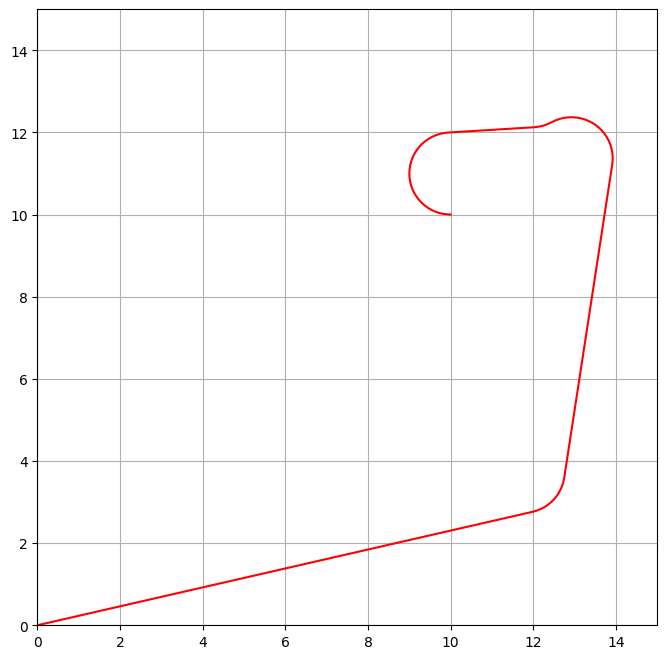

In [41]:
# rrtstar_dubins.draw_graph()
plt.figure(figsize=(8, 8))
plt.xlim(rnd_min, rnd_max)
plt.ylim(rnd_min, rnd_max)
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
# plt.scatter([x for (x, y) in path], [y for (x, y) in path])
plt.grid(True)
plt.show()

In [7]:
import numpy as np
from dubins_planner import DubinsPath
import matplotlib.pyplot as plt

In [8]:
dubins = DubinsPath()

In [9]:
start_x = 1.0  # [m]
start_y = 1.0  # [m]
start_yaw = np.deg2rad(45.0)  # [rad]

end_x = -3.0  # [m]
end_y = -3.0  # [m]
end_yaw = np.deg2rad(-45.0)  # [rad]

curvature = 1.0

path_x, path_y, path_yaw, mode, lengths = dubins.plan_dubins_path(start_x,
                                                                  start_y,
                                                                  start_yaw,
                                                                  end_x,
                                                                  end_y,
                                                                  end_yaw,
                                                                  curvature)

In [12]:
path_x

array([ 1.        ,  1.0670603 ,  1.12638537,  1.17738247,  1.21954204,
        1.25244285,  1.27575615,  1.28924901,  1.29278661,  1.28633361,
        1.26995448,  1.24381288,  1.20817   ,  1.16338198,  1.10989632,
        1.04824744,  0.97905131,  0.90299932,  0.82085134,  0.73342818,
        0.64160335,  0.54629431,  0.44845338,  0.34905814,  0.24910172,
        0.14958285,  0.05149589, -0.04417911, -0.1364862 , -0.22450306,
       -0.30735027, -0.38420005, -0.45428454, -0.54691136, -0.60120024,
       -0.65548912, -0.709778  , -0.76406689, -0.81835577, -0.87264465,
       -0.92693353, -0.98122242, -1.0355113 , -1.08980018, -1.14408906,
       -1.19837794, -1.25266683, -1.30695571, -1.36124459, -1.41553347,
       -1.46982235, -1.52411124, -1.57840012, -1.632689  , -1.68697788,
       -1.74126677, -1.79555565, -1.84984453, -1.90413341, -1.95842229,
       -2.01271118, -2.06700006, -2.12128894, -2.17557782, -2.2298667 ,
       -2.28415559, -2.33844447, -2.39273335, -2.44702223, -2.50

In [13]:
path_y

array([ 1.        ,  1.07412547,  1.15457549,  1.24054621,  1.33117866,
        1.42556725,  1.52276889,  1.62181238,  1.7217081 ,  1.82145793,
        1.9200652 ,  2.01654466,  2.10993231,  2.19929507,  2.28374005,
        2.3624235 ,  2.43455923,  2.49942651,  2.55637719,  2.60484224,
        2.64433741,  2.67446808,  2.6949332 ,  2.70552829,  2.70614747,
        2.69678458,  2.67753315,  2.64858553,  2.61023098,  2.56285271,
        2.5069241 ,  2.44300399,  2.37173103,  2.2499956 ,  2.16601514,
        2.08203469,  1.99805423,  1.91407377,  1.83009331,  1.74611286,
        1.6621324 ,  1.57815194,  1.49417148,  1.41019103,  1.32621057,
        1.24223011,  1.15824965,  1.07426919,  0.99028874,  0.90630828,
        0.82232782,  0.73834736,  0.65436691,  0.57038645,  0.48640599,
        0.40242553,  0.31844508,  0.23446462,  0.15048416,  0.0665037 ,
       -0.01747676, -0.10145721, -0.18543767, -0.26941813, -0.35339859,
       -0.43737904, -0.5213595 , -0.60533996, -0.68932042, -0.77

In [24]:
path_yaw

array([ 0.78539816,  0.88539816,  0.98539816,  1.08539816,  1.18539816,
        1.28539816,  1.38539816,  1.48539816,  1.58539816,  1.68539816,
        1.78539816,  1.88539816,  1.98539816,  2.08539816,  2.18539816,
        2.28539816,  2.38539816,  2.48539816,  2.58539816,  2.68539816,
        2.78539816,  2.88539816,  2.98539816,  3.08539816, -3.09778714,
       -2.99778714, -2.89778714, -2.79778714, -2.69778714, -2.59778714,
       -2.49778714, -2.39778714, -2.29778714, -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.14

In [10]:
cpp_path_x = [1, 1.06706, 1.12639, 1.17738, 1.21954, 1.25244, 1.27576, 1.28925, 1.29279, 1.28633, 1.26995, 1.24381, 1.20817, 1.16338, 1.1099, 1.04825, 0.979051, 0.902999, 0.820851, 0.733428, 0.641603, 0.546294, 0.448453, 0.349058, 0.249102, 0.149583, 0.0514959, -0.0441791, -0.136486, -0.224503, -0.30735, -0.3842, -0.454285, -0.546911, -0.6012, -0.655489, -0.709778, -0.764067, -0.818356, -0.872645, -0.926934, -0.981222, -1.03551, -1.0898, -1.14409, -1.19838, -
              1.25267, -1.30696, -1.36124, -1.41553, -1.46982, -1.52411, -1.5784, -1.63269, -1.68698, -1.74127, -1.79556, -1.84984, -1.90413, -1.95842, -2.01271, -2.067, -2.12129, -2.17558, -2.22987, -2.28416, -2.33844, -2.39273, -2.44702, -2.50131, -2.5556, -2.60989, -2.66418, -2.71847, -2.77276, -2.82704, -2.88133, -2.93562, -2.98991, -3.0442, -3.1327, -3.1827, -3.22381, -3.25562, -3.27782, -3.29017, -3.29255, -3.28495, -3.26744, -3.24018, -3.20347, -3.15765, -3.1032, -3]
cpp_path_y = [1, 1.07413, 1.15458, 1.24055, 1.33118, 1.42557, 1.52277, 1.62181, 1.72171, 1.82146, 1.92007, 2.01654, 2.10993, 2.1993, 2.28374, 2.36242, 2.43456, 2.49943, 2.55638, 2.60484, 2.64434, 2.67447, 2.69493, 2.70553, 2.70615, 2.69678, 2.67753, 2.64859, 2.61023, 2.56285, 2.50692, 2.443, 2.37173, 2.25, 2.16602, 2.08203, 1.99805, 1.91407, 1.83009, 1.74611, 1.66213, 1.57815, 1.49417, 1.41019, 1.32621, 1.24223, 1.15825, 1.07427, 0.990289,
              0.906308, 0.822328, 0.738347, 0.654367, 0.570386, 0.486406, 0.402426, 0.318445, 0.234465, 0.150484, 0.0665037, -0.0174768, -0.101457, -0.185438, -0.269418, -0.353399, -0.437379, -0.52136, -0.60534, -0.68932, -0.773301, -0.857281, -0.941262, -1.02524, -1.10922, -1.1932, -1.27718, -1.36116, -1.44514, -1.52912, -1.61311, -1.75, -1.83656, -1.92767, -2.02243, -2.11989, -2.21909, -2.31902, -2.41869, -2.5171, -2.61327, -2.70624, -2.79508, -2.8789, -3]

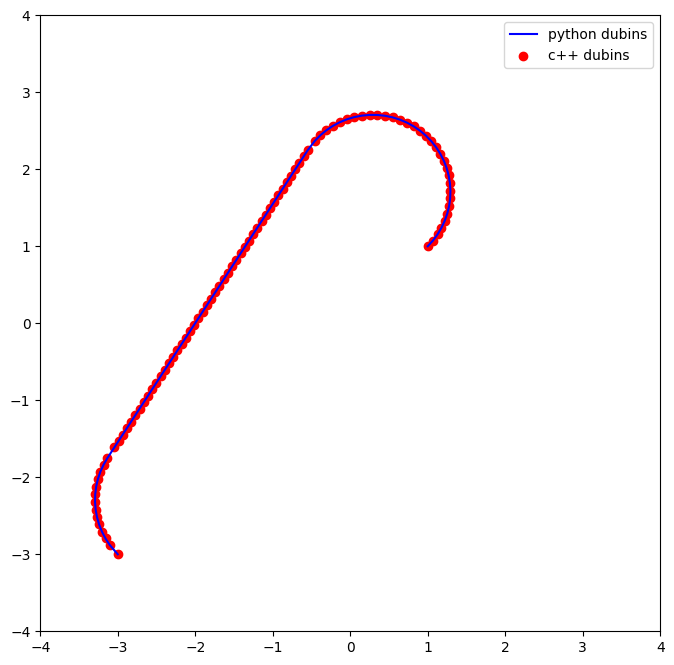

In [23]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.plot(path_x, path_y, color="blue", label='python dubins')
plt.scatter(cpp_path_x, cpp_path_y, color="red", label='c++ dubins')
plt.legend()
plt.show()

In [4]:
def angle_mod(x, zero_2_2pi=False, degree=False):
    if degree:
        x = x * (np.pi / 180.0)

    if zero_2_2pi:
        mod_angle = x % (2.0 * np.pi)
    else:
        mod_angle = (x + np.pi) % (2.0 * np.pi) - np.pi

    if degree:
        mod_angle = mod_angle * (180.0 / np.pi)

    return mod_angle

In [10]:
angle_mod(3.14, True, False)

3.14

In [12]:
angle_mod(-4.71238898, True, False)

1.5707963271795862

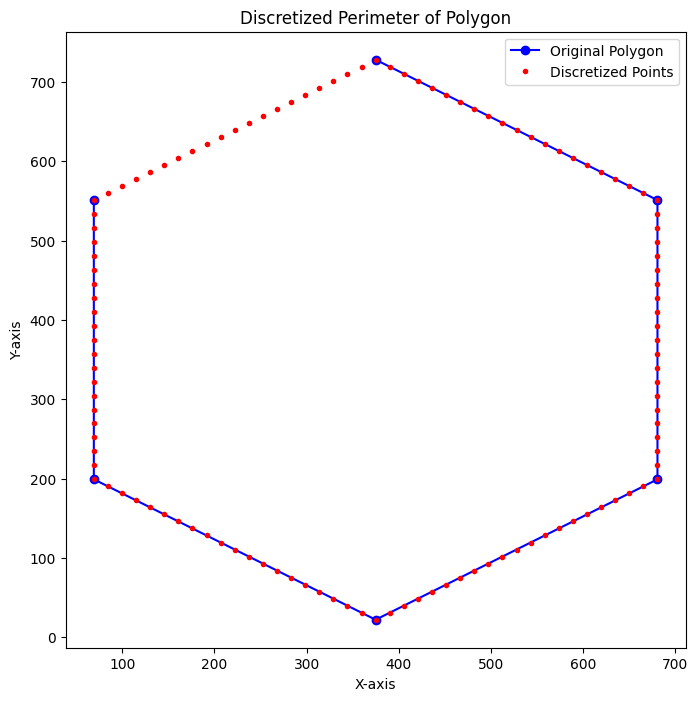

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def discretize_polygon(polygon_vertices, num_points_per_edge):
    points = []

    for i in range(len(polygon_vertices)):
        start_point = polygon_vertices[i]
        # Wrap around for the last edge
        end_point = polygon_vertices[(i + 1) % len(polygon_vertices)]

        x_vals = np.linspace(
            start_point[0], end_point[0], num_points_per_edge, endpoint=False)
        y_vals = np.linspace(
            start_point[1], end_point[1], num_points_per_edge, endpoint=False)

        edge_points = np.column_stack((x_vals, y_vals))
        points.extend(edge_points)

    return np.array(points)


# Example polygon vertices
polygon_vertices = np.array([[69, 551], [69, 199], [375, 22], [
                            681, 199], [681, 551], [375, 728]])

# Discretize the perimeter with 100 points per edge
discretized_points = discretize_polygon(
    polygon_vertices, num_points_per_edge=20)

# Plot the original polygon and the discretized points
plt.figure(figsize=(8, 8))
plt.plot(polygon_vertices[:, 0], polygon_vertices[:,
         1], 'bo-', label='Original Polygon')
plt.plot(discretized_points[:, 0], discretized_points[:,
         1], 'r.', label='Discretized Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Discretized Perimeter of Polygon')
plt.legend()
plt.show()

In [22]:
discretized_points

array([[ 69.  , 551.  ],
       [ 69.  , 543.96],
       [ 69.  , 536.92],
       [ 69.  , 529.88],
       [ 69.  , 522.84],
       [ 69.  , 515.8 ],
       [ 69.  , 508.76],
       [ 69.  , 501.72],
       [ 69.  , 494.68],
       [ 69.  , 487.64],
       [ 69.  , 480.6 ],
       [ 69.  , 473.56],
       [ 69.  , 466.52],
       [ 69.  , 459.48],
       [ 69.  , 452.44],
       [ 69.  , 445.4 ],
       [ 69.  , 438.36],
       [ 69.  , 431.32],
       [ 69.  , 424.28],
       [ 69.  , 417.24],
       [ 69.  , 410.2 ],
       [ 69.  , 403.16],
       [ 69.  , 396.12],
       [ 69.  , 389.08],
       [ 69.  , 382.04],
       [ 69.  , 375.  ],
       [ 69.  , 367.96],
       [ 69.  , 360.92],
       [ 69.  , 353.88],
       [ 69.  , 346.84],
       [ 69.  , 339.8 ],
       [ 69.  , 332.76],
       [ 69.  , 325.72],
       [ 69.  , 318.68],
       [ 69.  , 311.64],
       [ 69.  , 304.6 ],
       [ 69.  , 297.56],
       [ 69.  , 290.52],
       [ 69.  , 283.48],
       [ 69.  , 276.44],


In [ ]:
# #include <iostream>
# #include <vector>
# #include <Eigen/Dense>

# using namespace Eigen;

# std::vector<Vector2d> discretizePolygon(const std::vector<Vector2d>& polygonVertices, int numPointsPerEdge) {
#     std::vector<Vector2d> points;

#     for (size_t i = 0; i < polygonVertices.size(); ++i) {
#         const Vector2d& startPoint = polygonVertices[i];
#         const Vector2d& endPoint = polygonVertices[(i + 1) % polygonVertices.size()];

#         VectorXd xVals = VectorXd::LinSpaced(numPointsPerEdge, startPoint.x(), endPoint.x());
#         VectorXd yVals = VectorXd::LinSpaced(numPointsPerEdge, startPoint.y(), endPoint.y());

#         MatrixXd edgePoints = Map<MatrixXd>(xVals.data(), numPointsPerEdge, 1).colwise().replicate(1, numPointsPerEdge);
#         edgePoints.rowwise() += yVals.transpose();

#         for (int j = 0; j < numPointsPerEdge; ++j) {
#             points.emplace_back(edgePoints.row(j));
#         }
#     }

#     return points;
# }

# int main() {
#     std::vector<Vector2d> polygonVertices = {
#         Vector2d(69, 551),
#         Vector2d(69, 199),
#         Vector2d(375, 22),
#         Vector2d(681, 199),
#         Vector2d(681, 551),
#         Vector2d(375, 728)
#     };

#     int numPointsPerEdge = 100;

#     std::vector<Vector2d> discretizedPoints = discretizePolygon(polygonVertices, numPointsPerEdge);

#     // Print the discretized points
#     for (const auto& point : discretizedPoints) {
#         std::cout << point.x() << ", " << point.y() << std::endl;
#     }

#     return 0;
# }